##Import all the packages requried

1.tensorflow keras -->model


2.sklearn.model_selection ---> train -test split

In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

##Download the dataset
Here we are using english -spanish dataset[you can use other datset also]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


By using tf.keras.utils.get_file ----we are downloading data in cache dir of keras ~/keras..you can check file downloaded here .....cd ~/keras/datasets

In [3]:
# Download the file --- 
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"


2646016/2638744 [==============================] - 0s 0us/step


In [ ]:
ls

spa-eng/  spa-eng.zip


In [ ]:
cd spa-eng

/root/.keras/datasets/spa-eng


In [ ]:
ls

_about.txt  spa.txt


In [ ]:
num_lines = sum(1 for line in open('spa.txt'))

In [ ]:
print(num_lines)

118964


In [ ]:
file1=open("spa.txt")
nlines=210
for i in range(nlines):
  readl=file1.readline()
  print(readl)


Go.	Ve.

Go.	Vete.

Go.	Vaya.

Go.	Váyase.

Hi.	Hola.

Run!	¡Corre!

Run.	Corred.

Who?	¿Quién?

Fire!	¡Fuego!

Fire!	¡Incendio!

Fire!	¡Disparad!

Help!	¡Ayuda!

Help!	¡Socorro! ¡Auxilio!

Help!	¡Auxilio!

Jump!	¡Salta!

Jump.	Salte.

Stop!	¡Parad!

Stop!	¡Para!

Stop!	¡Pare!

Wait!	¡Espera!

Wait.	Esperen.

Go on.	Continúa.

Go on.	Continúe.

Hello!	Hola.

I ran.	Corrí.

I ran.	Corría.

I try.	Lo intento.

I won!	¡He ganado!

Oh no!	¡Oh, no!

Relax.	Tomátelo con soda.

Smile.	Sonríe.

Attack!	¡Al ataque!

Attack!	¡Atacad!

Get up.	Levanta.

Go now.	Ve ahora mismo.

Got it!	¡Lo tengo!

Got it?	¿Lo pillas?

Got it?	¿Entendiste?

He ran.	Él corrió.

Hop in.	Métete adentro.

Hug me.	Abrázame.

I fell.	Me caí.

I know.	Yo lo sé.

I left.	Salí.

I lied.	Mentí.

I lost.	Perdí.

I quit.	Dimito.

I quit.	Renuncié.

I work.	Estoy trabajando.

I'm 19.	Tengo diecinueve.

I'm up.	Estoy levantado.

Listen.	Escucha.

Listen.	Escuche.

Listen.	Escuchen.

No way!	¡No puede ser!

No way!	De ninguna ma

##Preparing the data
1.Add "</start/> and </end/>" token to each sentance like ...

"</start/>call tom</end/>"

"</start/>¡Llámalo a Tomás!</end/>"


2.Clean the sentances by removing special characters etc

3.Create word index and reverse word index

{dict having word -->id and id-->word}

4.Pad each sentance to max length
say max_length = 20 

In [4]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
                 if unicodedata.category(c) != 'Mn')


#in this step we are spacing the word and punctuations
#keeping the dataset with only words and punctuations and removing extra spaces
#stripping the whitespaces
#finally adding start and end token to the sentance
def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w


####Citing an example to preprocess sentance :

In [ ]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))


<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [5]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in line.split('\t')]
                for line in lines[:num_examples]]

  return zip(*word_pairs)


In [6]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [7]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [8]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

##Limiting the size of dataset
Training on complete set takes long time.So have considered only 30,000 samples


In [9]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file,
                                                                num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
input_tensor.shape[0]

30000

In [ ]:
input_tensor.shape[1]

16

In [ ]:
target_tensor.shape[1]

11

In [10]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [ ]:
inp_lang.word_index['<start>']

1

In [ ]:
input_tensor[0]

array([  1, 135,   3,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0], dtype=int32)

In [ ]:
for i in input_tensor[0]:
  if i!=0:
    print(i,"----vector equals to word ----",inp_lang.index_word[i])


1 ----vector equals to word ---- <start>
135 ----vector equals to word ---- ve
3 ----vector equals to word ---- .
2 ----vector equals to word ---- <end>


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t != 0:
      print(f'{t} ----> {lang.index_word[t]}')

In [ ]:
print("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print()
print("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
145 ----> cuando
224 ----> uno
8 ----> no
106 ----> quiere
32 ----> ,
98 ----> dos
8 ----> no
9039 ----> pelean
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
10 ----> it
976 ----> takes
208 ----> two
15 ----> to
3177 ----> tango
3 ----> .
2 ----> <end>


##Creating tf.Dataset

In [11]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = BUFFER_SIZE//BATCH_SIZE

In [ ]:
steps_per_epoch

375

In [ ]:
len(inp_lang.word_index)

9413

In [ ]:
len(targ_lang.word_index)

4934

In [12]:
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)

In [14]:
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [39]:
#l=list(dataset.as_numpy_iterator())

In [38]:
#len(l)

In [ ]:
inp,tar = zip(*list(dataset.as_numpy_iterator()))

In [ ]:
len(inp)

375

In [15]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

##Encoder Model
vocab_inp and embedding size ---> embedding layer

enc_units --->RNN model

batch_size ---> initializing embeddings

here there are 2 layers -- embedding and GRU

In [16]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [17]:
#initilaize encoder object with variables/parameters required
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)


In [18]:
# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units)', sample_output.shape)
print('Encoder Hidden state shape: (batch size, units)', sample_hidden.shape)

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


##Attention Mechanism 
similar to jay alammar blog
Here hidden state of encoder and encoder output is passed

Let's decide on notation before writing the simplified form:

FC = Fully connected (dense) layer
EO = Encoder output
H = hidden state
X = input to the decoder
And the pseudo-code:

###score = FC(tanh(FC(EO) + FC(H)))
###attention weights = softmax(score, axis = 1). 
Softmax by default is applied on the last axis but here we want to apply it on the 1st axis, since the shape of score is (batch_size, max_length, hidden_size). Max_length is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.

###context vector = sum(attention weights * EO, axis = 1).
Same reason as above for choosing axis as 1.

###embedding output = The input to the decoder X is passed through an embedding layer.

###merged vector = concat(embedding output, context vector)
This merged vector is then given to the GRU

In [19]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [20]:
#initializing the attention mechanism with 10units
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units)", attention_result.shape)
print("Attention weights shape: (batch_size, sequence_length, 1)", attention_weights.shape)

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


##Decoder Model
vocab_tar,embedding size ---> embedding

dec_units ---> RNN model

Feedforward Neural network [FC layer] ---> vocab_tar [having the o/p]


there are 3 layers here

In [21]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [22]:
#defining the decoder object with parameters
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print('Decoder output shape: (batch_size, vocab size)', sample_decoder_output.shape)

Decoder output shape: (batch_size, vocab size) (64, 4935)


In [23]:
tf.random.uniform((BATCH_SIZE, 1))[1:4]

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.9799131 ],
       [0.4418857 ],
       [0.73093915]], dtype=float32)>

## Define the optimizer and the loss function

In [24]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

##Saving the checkpoints of the model..basically we are svaing the objects

In [25]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

###Training The Model

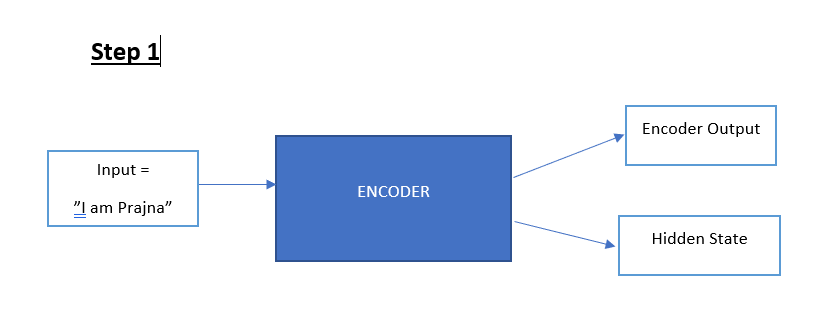

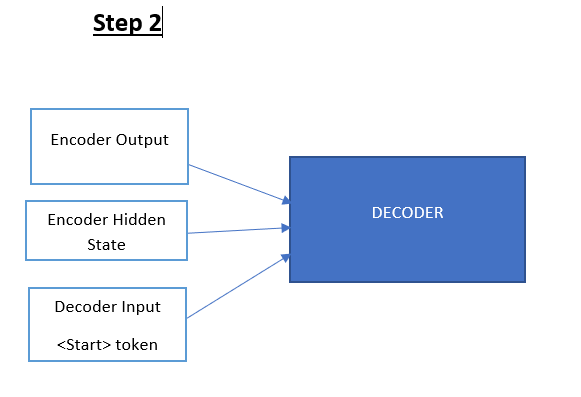

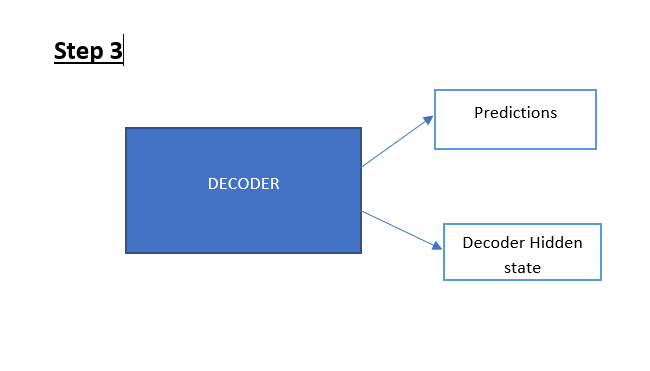

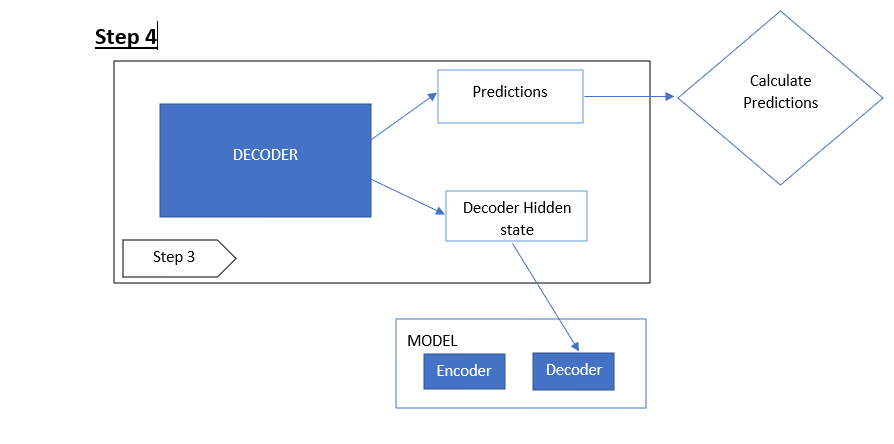

Basicaly target language equivalent of i that is juis in case of eng-spanish in spanish

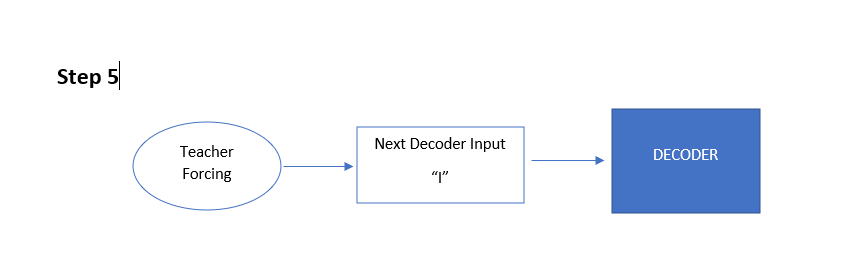

##Step 6
The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [26]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [27]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)

  print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
  print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 4.6865
Epoch 1 Batch 100 Loss 2.2209
Epoch 1 Batch 200 Loss 1.9036
Epoch 1 Batch 300 Loss 1.6853
Epoch 1 Loss 2.0412
Time taken for 1 epoch 44.65 sec

Epoch 2 Batch 0 Loss 1.6413
Epoch 2 Batch 100 Loss 1.5468
Epoch 2 Batch 200 Loss 1.3762
Epoch 2 Batch 300 Loss 1.2769
Epoch 2 Loss 1.3796
Time taken for 1 epoch 34.16 sec

Epoch 3 Batch 0 Loss 0.9772
Epoch 3 Batch 100 Loss 1.0102
Epoch 3 Batch 200 Loss 0.8306
Epoch 3 Batch 300 Loss 0.8174
Epoch 3 Loss 0.9512
Time taken for 1 epoch 34.14 sec

Epoch 4 Batch 0 Loss 0.6937
Epoch 4 Batch 100 Loss 0.6143
Epoch 4 Batch 200 Loss 0.6249
Epoch 4 Batch 300 Loss 0.6207
Epoch 4 Loss 0.6371
Time taken for 1 epoch 34.42 sec

Epoch 5 Batch 0 Loss 0.4650
Epoch 5 Batch 100 Loss 0.4329
Epoch 5 Batch 200 Loss 0.3464
Epoch 5 Batch 300 Loss 0.3999
Epoch 5 Loss 0.4297
Time taken for 1 epoch 33.92 sec

Epoch 6 Batch 0 Loss 0.2547
Epoch 6 Batch 100 Loss 0.2674
Epoch 6 Batch 200 Loss 0.3286
Epoch 6 Batch 300 Loss 0.3634
Epoch 6 Loss 0.2969
Ti

##Translate
*No teacher forcing 

*At 1st timestep within decoder,decoder input is </start/> tag

*From next time steps,Decoder input is always the previous prediction

*stop translating if you encounter </end/> token

*save attention weights for each step


In [28]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [29]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [30]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input:', sentence)
  print('Predicted translation:', result)

  attention_plot = attention_plot[:len(result.split(' ')),
                                  :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

##Restore latest checkpoint and Test

In [31]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


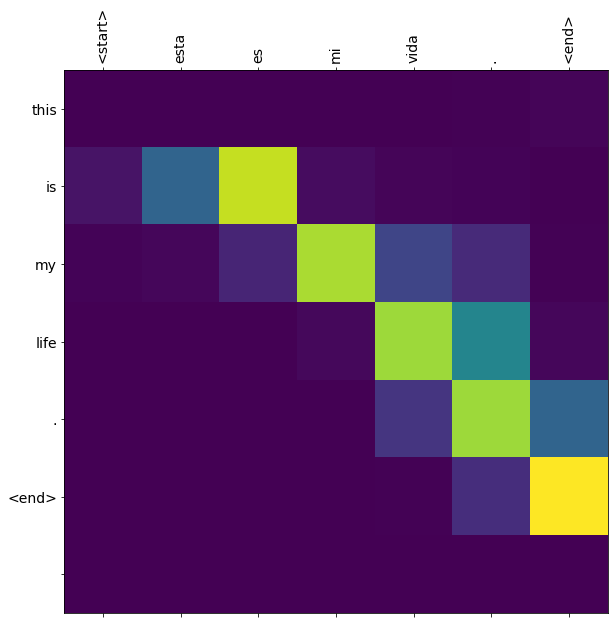

In [32]:
translate(u'esta es mi vida.')

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


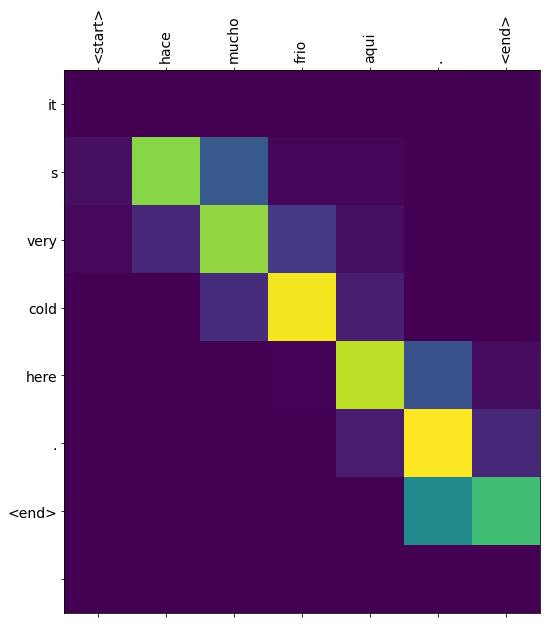

In [35]:
translate(u'hace mucho frio aqui.')